# One Store One Product
Since we didn't make much progress in the last days, and this project is really huge for one person, we'll focus on one store and one product only at the beginning.

## Predict items sold in the next 7 days for each store and item in the data set.

In [55]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import re
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from fbprophet import Prophet # DON'T insall
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor
import math

In [6]:
df = pd.read_csv('case_study_data_ver1.csv', sep = ';')

In an earlier EDA we've seen some seasonality in sales of store 3 in combination with item 4.

In [7]:
df = df[(df.STORE_ID==3)&(df.ITEM_ID==4)]

## Cleaning
### Missing Values

In [8]:
def check_nulls(df):
    print('{} rows'.format(len(df)))
    cols = list(df.keys())
    print('{} columns'.format(len(cols)))

    if df.isna().sum().sum() > 0:
        for col in range(len(cols)):
            if df[cols[col]].isna().sum() > 0:
                print('{} has {} NULL values'.format(cols[col],df[cols[col]].isna().sum()))
    else:
        print('No NULL values found')

In [9]:
check_nulls(df)

1169 rows
35 columns
NUM_HOLIDAY_WHIT_TO has 20 NULL values


If this would be the case only for this store-product combination, we may be able to simply replace the NULLs, since DATE_ID's are the same.

In [10]:
df = pd.read_csv('case_study_data_ver1.csv', sep = ';')
df = df[(df.STORE_ID==4)&(df.ITEM_ID==3)]
check_nulls(df)

955 rows
35 columns
NUM_HOLIDAY_WHIT_TO has 19 NULL values


In [11]:
df = pd.read_csv('case_study_data_ver1.csv', sep = ';')
df = df[(df.STORE_ID==10)&(df.ITEM_ID==13)]
check_nulls(df)

1207 rows
35 columns
NUM_HOLIDAY_WHIT_TO has 20 NULL values


It looks similar for other combinations, too. Another way would simply to calculate it, from previous DATE_ID's. But it could also be that the data in these rows are generally odd. Let's have a look.

In [12]:
df = pd.read_csv('case_study_data_ver1.csv', sep = ';')
df = df[(df.STORE_ID==3)&(df.ITEM_ID==4)]
df[df.NUM_HOLIDAY_WHIT_TO.isna()]

,ITEM_ID,DATE_ID,STORE_ID,CAT_DAYOFWEEK,DUM_HOLIDAY,DUM_FREEWEEKDAY,DUM_WORKSATURDAY,DUM_HOLIDAY_SNGL,DUM_HOLIDAY_WHIT,DUM_HOLIDAY_XMAS,...,NUM_HOLIDAY_WHIT_TO,NUM_HOLIDAY_XMAS_FROM,NUM_HOLIDAY_XMAS_TO,NUM_SCHOOLBREAK_FROM_END,NUM_SCHOOLBREAK_TO_START,NUM_SCHOOLBREAK_FROM_START,NUM_SCHOOLBREAK_TO_END,QTY,PRICE,CUSTOMER
956725,4.0,1257.0,3.0,1,0,0,0,0,0,0,...,NaN,168.0,197.0,50.0,4.0,0.0,0.0,11.0,922.95,2650.0
957884,4.0,1258.0,3.0,2,0,0,0,0,0,0,...,NaN,169.0,196.0,51.0,3.0,0.0,0.0,3.0,922.95,2102.0
959035,4.0,1259.0,3.0,3,0,0,0,0,0,0,...,NaN,170.0,195.0,52.0,2.0,0.0,0.0,16.0,922.95,2354.0
960218,4.0,1260.0,3.0,4,0,0,0,0,0,0,...,NaN,171.0,194.0,53.0,1.0,0.0,0.0,16.0,922.95,2221.0
961394,4.0,1261.0,3.0,5,0,0,0,0,0,0,...,NaN,172.0,193.0,0.0,0.0,1.0,78.0,10.0,922.95,2249.0
962551,4.0,1262.0,3.0,6,0,0,0,0,0,0,...,NaN,173.0,192.0,0.0,0.0,2.0,77.0,7.0,922.95,1441.0
963719,4.0,1263.0,3.0,0,0,0,0,0,0,0,...,NaN,174.0,191.0,0.0,0.0,3.0,76.0,8.0,922.95,2207.0
964874,4.0,1264.0,3.0,1,0,0,0,0,0,0,...,NaN,175.0,190.0,0.0,0.0,4.0,75.0,19.0,922.95,2041.0
966014,4.0,1265.0,3.0,2,0,0,0,0,0,0,...,NaN,176.0,189.0,0.0,0.0,5.0,74.0,6.0,922.95,1737.0
967161,4.0,1266.0,3.0,3,0,0,0,0,0,0,...,NaN,177.0,188.0,0.0,0.0,6.0,73.0,6.0,922.95,2256.0


Interestingly only DATE_IDs 1257:1276 are affected. Guess we can simply replace the NAN's

In [25]:
df[(df.DATE_ID > 1250) & (df.DATE_ID < 1300) &(df.NUM_HOLIDAY_WHIT_TO.isna()==False)]

,ITEM_ID,DATE_ID,STORE_ID,CAT_DAYOFWEEK,DUM_HOLIDAY,DUM_FREEWEEKDAY,DUM_WORKSATURDAY,DUM_HOLIDAY_SNGL,DUM_HOLIDAY_WHIT,DUM_HOLIDAY_XMAS,...,NUM_HOLIDAY_WHIT_TO,NUM_HOLIDAY_XMAS_FROM,NUM_HOLIDAY_XMAS_TO,NUM_SCHOOLBREAK_FROM_END,NUM_SCHOOLBREAK_TO_START,NUM_SCHOOLBREAK_FROM_START,NUM_SCHOOLBREAK_TO_END,QTY,PRICE,CUSTOMER
952091,4.0,1251.0,3.0,2,0,0,0,0,0,0,...,4.0,162.0,203.0,44.0,10.0,0.0,0.0,12.0,922.95,1964.0
953244,4.0,1252.0,3.0,3,0,0,0,0,0,0,...,3.0,163.0,202.0,45.0,9.0,0.0,0.0,7.0,922.95,2349.0
954394,4.0,1253.0,3.0,4,0,0,0,0,0,0,...,2.0,164.0,201.0,46.0,8.0,0.0,0.0,21.0,922.95,2380.0
955570,4.0,1254.0,3.0,5,0,0,0,0,0,0,...,1.0,165.0,200.0,47.0,7.0,0.0,0.0,48.0,922.95,2785.0


Ok, looks like we're close to Pfingsten. But let's have a closer look to related Variables as well.

In [31]:
whits=[]
for string in list(df.keys()):
    if len(re.compile('whit').findall(string.strip().lower())) >0:
        whits.append(string)
        print(string)

DUM_HOLIDAY_WHIT
NUM_HOLIDAY_WHIT_FROM
NUM_HOLIDAY_WHIT_TO


In [34]:
df[df.NUM_HOLIDAY_WHIT_TO.isna()][whits]

,DUM_HOLIDAY_WHIT,NUM_HOLIDAY_WHIT_FROM,NUM_HOLIDAY_WHIT_TO
956725,0,2.0,NaN
957884,0,3.0,NaN
959035,0,4.0,NaN
960218,0,5.0,NaN
961394,0,6.0,NaN
962551,0,7.0,NaN
963719,0,8.0,NaN
964874,0,9.0,NaN
966014,0,10.0,NaN
967161,0,11.0,NaN


In [36]:
df[(df.DATE_ID > 1250) & (df.DATE_ID < 1300) & (df.NUM_HOLIDAY_WHIT_TO.isna()==False)][whits]

,DUM_HOLIDAY_WHIT,NUM_HOLIDAY_WHIT_FROM,NUM_HOLIDAY_WHIT_TO
952091,0,381.0,4.0
953244,0,382.0,3.0
954394,0,383.0,2.0
955570,0,384.0,1.0


In [38]:
df.DATE_ID.max()

1276.0

Ok, wait. NA's are starting with one day after Pfingsten (stores are closed on Pfingsten). And it seems like our data end short time after Pfingsten, which is a moving holiday. Every year it has a slightly different date. So we may not know NUM_HOLIDAY_WHIT_TO in advance. Except, we calcuate it. Unfortunately we don't know the underlying date. So we can't use that variable at prediction time. 

BTW, whats the price of ITEM 4?

In [41]:
df[['QTY','PRICE']]

,QTY,PRICE
97,20.0,1101.45
681,7.0,1101.45
1192,4.0,1101.45
1790,8.0,1101.45
2431,7.0,1101.45
...,...,...
975284,10.0,922.95
976453,13.0,922.95
977637,15.0,922.95
978816,8.0,922.95


In [43]:
round(df.PRICE.mean(),2)

945.68

In average item 4 had a price of 945.68 phantasy currency.

In [45]:
df['QTY'] = df['QTY'].astype(str)
outtakes = df[df.QTY.str.contains('[a-zA-Z]|\.\d\d$|\.\d\d\d\d$')]
df = df.drop(outtakes.index)
df['QTY'] = df['QTY'].apply(lambda x: re.sub('\.','',re.sub('\..$','',x))).astype(float)
df = df.drop([key for key in list(df.keys()) if df[key].sum()==0], axis=1)

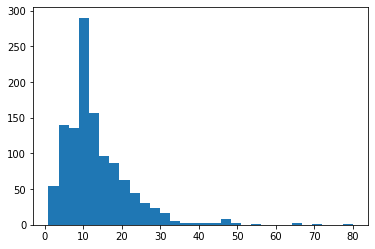

In [60]:
plt.hist(df.QTY,bins=30)
plt.show()

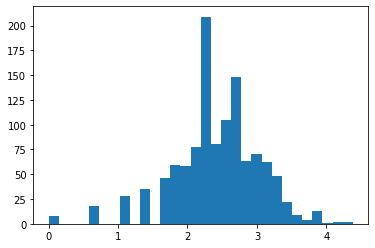

In [109]:
plt.hist(np.log(df.QTY),bins=30)
plt.show()

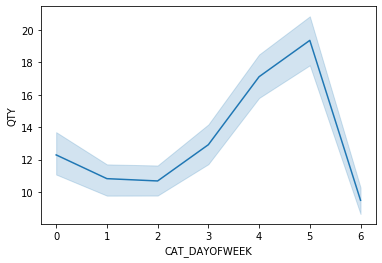

In [64]:
sns.lineplot(x="CAT_DAYOFWEEK", y="QTY", data=df)

Looks like we're selling the most on saturday.

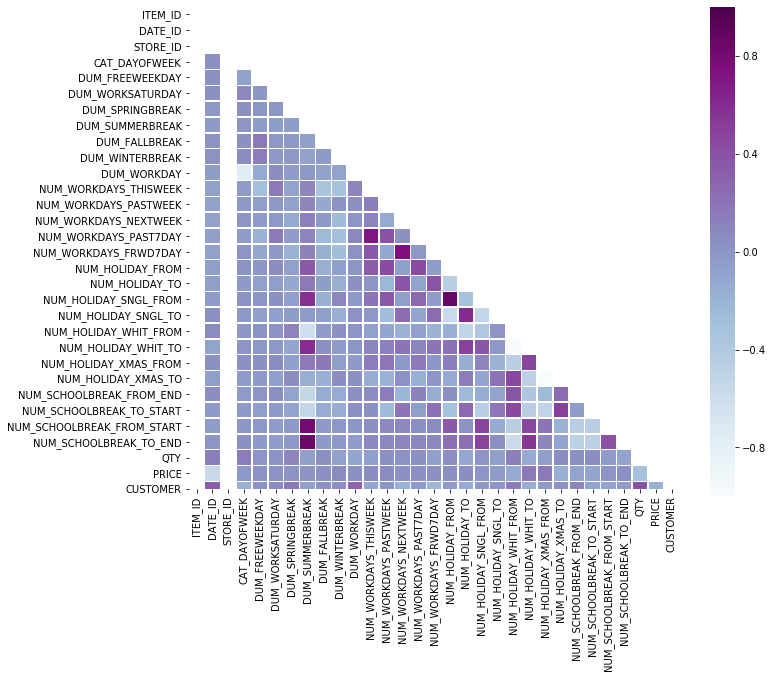

In [66]:
# Compute the correlation matrix 
corr_all = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask, square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

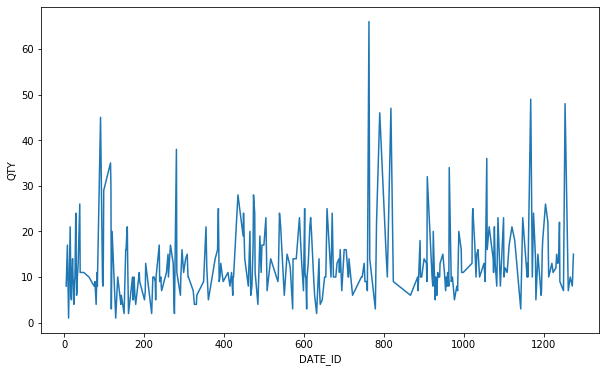

In [106]:
plt.figure(figsize = (10, 6))
sns.lineplot(x="DATE_ID", y="QTY", data=df.sample(frac=0.25))
plt.show()

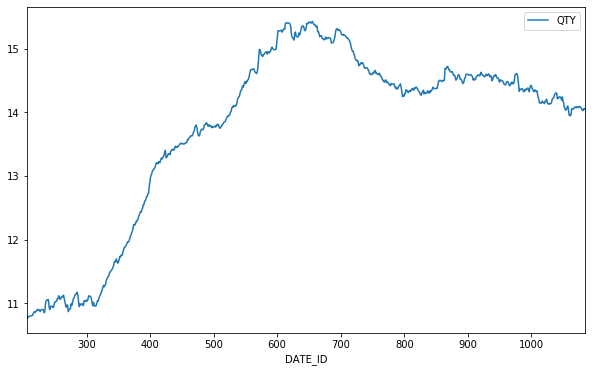

In [104]:
plt.figure(figsize = (10, 6))
decomposition = seasonal_decompose(df[['DATE_ID','QTY']], model = 'additive', freq = 365)
decomposition.trend.plot(x='DATE_ID',y='QTY',ax = plt.gca())
plt.show()

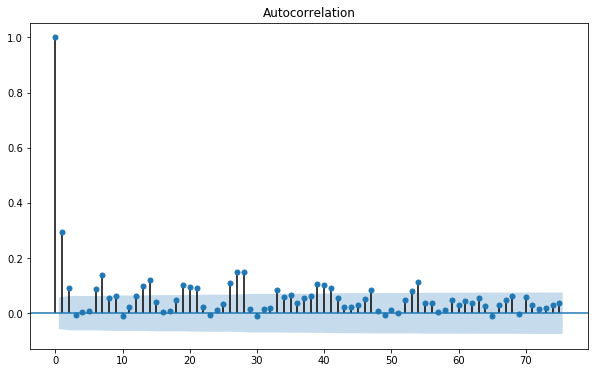

In [102]:
plt.figure(figsize = (10, 6))
plot_acf(df.QTY, lags = 75, ax = plt.gca());

Looks like observations are often correlated to previous observations.

## Modeling

In [110]:
list(df.keys())

['ITEM_ID',
 'DATE_ID',
 'STORE_ID',
 'CAT_DAYOFWEEK',
 'DUM_FREEWEEKDAY',
 'DUM_WORKSATURDAY',
 'DUM_SPRINGBREAK',
 'DUM_SUMMERBREAK',
 'DUM_FALLBREAK',
 'DUM_WINTERBREAK',
 'DUM_WORKDAY',
 'NUM_WORKDAYS_THISWEEK',
 'NUM_WORKDAYS_PASTWEEK',
 'NUM_WORKDAYS_NEXTWEEK',
 'NUM_WORKDAYS_PAST7DAY',
 'NUM_WORKDAYS_FRWD7DAY',
 'NUM_HOLIDAY_FROM',
 'NUM_HOLIDAY_TO',
 'NUM_HOLIDAY_SNGL_FROM',
 'NUM_HOLIDAY_SNGL_TO',
 'NUM_HOLIDAY_WHIT_FROM',
 'NUM_HOLIDAY_WHIT_TO',
 'NUM_HOLIDAY_XMAS_FROM',
 'NUM_HOLIDAY_XMAS_TO',
 'NUM_SCHOOLBREAK_FROM_END',
 'NUM_SCHOOLBREAK_TO_START',
 'NUM_SCHOOLBREAK_FROM_START',
 'NUM_SCHOOLBREAK_TO_END',
 'QTY',
 'PRICE',
 'CUSTOMER']

In [119]:
# Exclude: 
# - ID's, 
# - NANs
# - what we can't know at prediction time 
features = [col for col in list(df.keys()) if (col not in list(df.keys())[:3]) & \
                                              (col not in ['NUM_HOLIDAY_WHIT_TO', 'QTY', 'CUSTOMER'])]
features

['CAT_DAYOFWEEK',
 'DUM_FREEWEEKDAY',
 'DUM_WORKSATURDAY',
 'DUM_SPRINGBREAK',
 'DUM_SUMMERBREAK',
 'DUM_FALLBREAK',
 'DUM_WINTERBREAK',
 'DUM_WORKDAY',
 'NUM_WORKDAYS_THISWEEK',
 'NUM_WORKDAYS_PASTWEEK',
 'NUM_WORKDAYS_NEXTWEEK',
 'NUM_WORKDAYS_PAST7DAY',
 'NUM_WORKDAYS_FRWD7DAY',
 'NUM_HOLIDAY_FROM',
 'NUM_HOLIDAY_TO',
 'NUM_HOLIDAY_SNGL_FROM',
 'NUM_HOLIDAY_SNGL_TO',
 'NUM_HOLIDAY_WHIT_FROM',
 'NUM_HOLIDAY_XMAS_FROM',
 'NUM_HOLIDAY_XMAS_TO',
 'NUM_SCHOOLBREAK_FROM_END',
 'NUM_SCHOOLBREAK_TO_START',
 'NUM_SCHOOLBREAK_FROM_START',
 'NUM_SCHOOLBREAK_TO_END',
 'PRICE']

Before we start splitting our data set, we first exclude the last month. We can compare it with our designed model later.

In [124]:
df_new_data = df[-30:]
df = df.drop(df_new_data.index)

In [125]:
y = np.log(df.QTY)
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 20191102)

In [126]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat / y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

In [127]:
# base parameters
params = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', # regression task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.85, # 85% of features used
    'eta': 0.1, 
    'max_depth': 10, 
    'seed': 42} # for reproducible results

In [133]:
# XGB with xgboost library
dtrain = xgb.DMatrix(X_train[features], y_train)
dtest = xgb.DMatrix(X_test[features], y_test)

watchlist = [(dtrain, 'train'), (dtest, 'test')]

xgb_model = xgb.train(params, dtrain, 300, evals = watchlist,
                      early_stopping_rounds = 40, 
#                       feval = rmspe_xg, 
                      verbose_eval = True
                     )

[20:02:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:1.83315	test-rmse:1.82226
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 40 rounds.
[1]	train-rmse:1.66592	test-rmse:1.65941
[2]	train-rmse:1.51681	test-rmse:1.5126
[3]	train-rmse:1.38337	test-rmse:1.38128
[4]	train-rmse:1.26228	test-rmse:1.26573
[5]	train-rmse:1.15478	test-rmse:1.16757
[6]	train-rmse:1.05898	test-rmse:1.07675
[7]	train-rmse:0.97265	test-rmse:0.999526
[8]	train-rmse:0.894521	test-rmse:0.934198
[9]	train-rmse:0.824301	test-rmse:0.873188
[10]	train-rmse:0.762258	test-rmse:0.825426
[11]	train-rmse:0.705932	test-rmse:0.78234
[12]	train-rmse:0.657068	test-rmse:0.742848
[13]	train-rmse:0.611581	test-rmse:0.712225
[14]	train-rmse:0.571274	test-rmse:0.683119
[15]	train-rmse:0.535028	test-rmse:0.660126
[16]	train-rmse: